# Production scheduling -- the job shop problem

## Problem Description
- We have a number of jobs: Job 0, Job 1, Job 2, ...
- We have a number of machines: Machine 0, Machine 1, Machine 2, ...
- Each job must be processed on each machine in a specific order.
- for example: Job 0 must be processed on Machine 0, then on Machine 1, then on Machine 2.
- No machine can process more than one job at a time.
- We assume unlimited buffers between machines, so jobs can immediately move to the next machine if it's available.
- **Objective**: Minimize the total completion time (makespan), C_max.

the effect of the job shop problem is a schedule, frequentely presented as a Gantt chart.

# ![Job shop problem example](https://www.researchgate.net/publication/370490241/figure/fig1/AS:11431281155279843@1683131798236/Job-sequence-on-machines-for-a-job-shop-problem-with-3-machines-and-2-jobs.png)

The problem is NP-hard, the more jobs and machines, the harder it is to solve.



## Mini Problem Example

### Scenario Setup
- **Machines**: 0 and 1
- **Jobs**: 0 and 1
- Each job has two operations, one on each machine, but in different orders

### Job 0
- **Operation 1**: Machine 0 → Processing time = 5
- **Operation 2**: Machine 1 → Processing time = 6
- Thus, Job 0 must go first to Machine 0, then to Machine 1

### Job 1
- **Operation 1**: Machine 1 → Processing time = 4  
- **Operation 2**: Machine 0 → Processing time = 7
- Thus, Job 1 must go first to Machine 1, then to Machine 0

### Objective
Minimize the makespan (C_max)

In [3]:
!pip install pulp

import pulp

# 1) Create the problem
model = pulp.LpProblem("Small_Job_Shop", pulp.LpMinimize)

# 2) Decision variables
# Start times:
# s0_0: Start time of Job 0 on Machine 0
# s0_1: Start time of Job 0 on Machine 1
# s1_0: Start time of Job 1 on Machine 0
# s1_1: Start time of Job 1 on Machine 1
s0_0 = pulp.LpVariable("s0_0", lowBound=0, cat='Continuous')
s0_1 = pulp.LpVariable("s0_1", lowBound=0, cat='Continuous')
s1_0 = pulp.LpVariable("s1_0", lowBound=0, cat='Continuous')
s1_1 = pulp.LpVariable("s1_1", lowBound=0, cat='Continuous')

# Makespan
Cmax = pulp.LpVariable("Cmax", lowBound=0, cat='Continuous')

# 3) Processing times
# Job 0: M0=5, then M1=6
p0_m0 = 8 # processing time of Job 0 on Machine 0
p0_m1 = 3 # processing time of Job 0 on Machine 1

# Job 1: M1=4, then M0=7
p1_m1 = 6 # processing time of Job 1 on Machine 1
p1_m0 = 5 # processing time of Job 1 on Machine 0

# 4) Binary variables for machine usage ordering
# We need these to ensure no overlap on each machine - each machine can process only one job at a time.
# For Machine 0, let y0_01 = 1 if Job 0 finishes before Job 1 starts on M0, else 0.
# For Machine 1, let y1_01 = 1 if Job 0 finishes before Job 1 starts on M1, else 0.
y0_01 = pulp.LpVariable("y0_01", cat='Binary')  # ordering on Machine 0
y1_01 = pulp.LpVariable("y1_01", cat='Binary')  # ordering on Machine 1

# Define a "big M" large enough to cover maximum possible scheduling time
bigM = 9999

# 5) OBJECTIVE: minimize Cmax
model += Cmax, "Minimize_the_makespan"

# 6) CONSTRAINTS

# -- (A) Operation sequence for each job --

# Job 0 must finish on Machine 0 before starting on Machine 1:
model += s0_1 >= s0_0 + p0_m0, "Seq_Job0" # start time of Job 0 on Machine 1 must be greater than or equal to the start time of Job 0 on Machine 0 plus the processing time of Job 0 on Machine 0

# Job 1 must finish on Machine 1 before starting on Machine 0:
model += s1_0 >= s1_1 + p1_m1, "Seq_Job1" # start time of Job 1 on Machine 0 must be greater than or equal to the start time of Job 1 on Machine 1 plus the processing time of Job 1 on Machine 1

# -- (B) No overlap on Machine 0 --
# Machine 0 is used by:
#   - Job 0 (from s0_0 to s0_0 + p0_m0)
#   - Job 1 (from s1_0 to s1_0 + p1_m0)
# Use a big-M approach with binary y0_01:

# If y0_01 = 1, Job0 finishes before Job1 starts on M0:
#     s1_0 >= s0_0 + p0_m0 - bigM*(1 - y0_01)
model += s1_0 >= s0_0 + p0_m0 - bigM*(1 - y0_01), "NoOverlap0a"

# If y0_01 = 0, Job1 finishes before Job0 starts on M0:
#     s0_0 >= s1_0 + p1_m0 - bigM*(y0_01)
model += s0_0 >= s1_0 + p1_m0 - bigM*(y0_01), "NoOverlap0b"

# -- (C) No overlap on Machine 1 --
# Machine 1 is used by:
#   - Job 0 (from s0_1 to s0_1 + p0_m1)
#   - Job 1 (from s1_1 to s1_1 + p1_m1)
# Use a big-M approach with y1_01:

# If y1_01 = 1, Job0 finishes before Job1 starts on M1:
#     s1_1 >= s0_1 + p0_m1 - bigM*(1 - y1_01)
model += s1_1 >= s0_1 + p0_m1 - bigM*(1 - y1_01), "NoOverlap1a"

# If y1_01 = 0, Job1 finishes before Job0 starts on M1:
#     s0_1 >= s1_1 + p1_m1 - bigM*(y1_01)
model += s0_1 >= s1_1 + p1_m1 - bigM*(y1_01), "NoOverlap1b"

# -- (D) Makespan definition --
# Finish time for Job 0 = time it completes on Machine 1 = s0_1 + p0_m1
# Finish time for Job 1 = time it completes on Machine 0 = s1_0 + p1_m0

model += Cmax >= s0_1 + p0_m1, "Makespan_Job0"
model += Cmax >= s1_0 + p1_m0, "Makespan_Job1"

# 7) Solve the model
model.solve(pulp.PULP_CBC_CMD(msg=False))

# 8) Print results
print("Status:", pulp.LpStatus[model.status])
print("Objective (makespan) =", pulp.value(model.objective))

# Decision variable values:
print("--- Start Times ---")
print("s0_0 (Job0 on M0) =", pulp.value(s0_0))
print("s0_1 (Job0 on M1) =", pulp.value(s0_1))
print("s1_0 (Job1 on M0) =", pulp.value(s1_0))
print("s1_1 (Job1 on M1) =", pulp.value(s1_1))

print("--- Binary Orders ---")
print("y0_01 (Machine 0 order) =", pulp.value(y0_01))
print("y1_01 (Machine 1 order) =", pulp.value(y1_01))

Status: Optimal
Objective (makespan) = 13.0
--- Start Times ---
s0_0 (Job0 on M0) = 0.0
s0_1 (Job0 on M1) = 8.0
s1_0 (Job1 on M0) = 8.0
s1_1 (Job1 on M1) = 0.0
--- Binary Orders ---
y0_01 (Machine 0 order) = 1.0
y1_01 (Machine 1 order) = 0.0


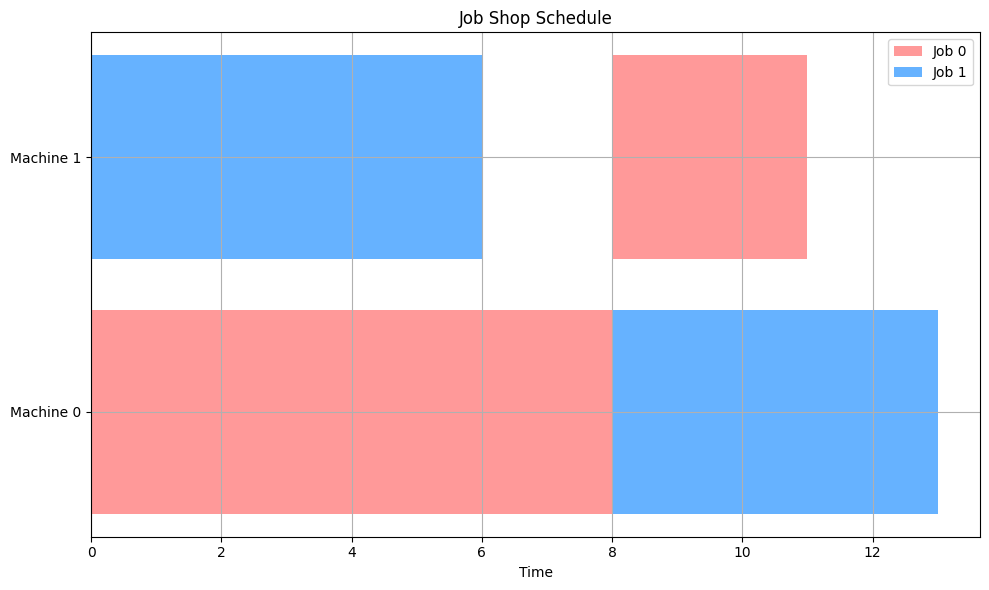

In [4]:
import matplotlib.pyplot as plt

# Create Gantt chart
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for each job
colors = ['#FF9999', '#66B2FF']

# For each machine
for m in range(2):
    # Plot Job 0 on this machine
    if m == 0:
        start = pulp.value(s0_0)
        duration = p0_m0
    else:
        start = pulp.value(s0_1)
        duration = p0_m1
    ax.barh(m, duration, left=start, color=colors[0], label='Job 0' if m==0 else "")

    # Plot Job 1 on this machine
    if m == 0:
        start = pulp.value(s1_0)
        duration = p1_m0
    else:
        start = pulp.value(s1_1)
        duration = p1_m1
    ax.barh(m, duration, left=start, color=colors[1], label='Job 1' if m==0 else "")

# Customize the chart
ax.set_yticks(range(2))
ax.set_yticklabels(['Machine 0', 'Machine 1'])
ax.set_xlabel('Time')
ax.set_title('Job Shop Schedule')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


# Excercise 1

Play with the code above to see how the schedule changes with different processing times.



#More general job shop problem example

## Data Setup
Let's define for each job:
- The machine sequence the job must follow
- The processing time on each machine (in hours)

### Job Specifications:

**Job 0:**
- Machine sequence: Machine 0 → Machine 1 → Machine 2
- Processing times: 5, 6, 4 hours respectively

**Job 1:**
- Machine sequence: Machine 1 → Machine 2 → Machine 0  
- Processing times: 4, 3, 7 hours respectively

**Job 2:**
- Machine sequence: Machine 0 → Machine 2 → Machine 1
- Processing times: 6, 4, 5 hours respectively

We will store this data in two parallel 2D lists:
- `machine_order`: Contains the sequence of machines for each job
- `processing_time`: Contains the corresponding processing times



In [12]:
import pulp

# -------------------------
# 1) PROBLEM PARAMETERS
# -------------------------
num_jobs = 3
num_machines = 4 # Increased to 4 machines

# machine_order[job] = list of machines in the order they must be processed
# Example: Job 0 -> Machine 0 -> Machine 1 -> Machine 2 -> Machine 3
machine_order = [
    [0, 1, 2, 3],  # Job 0 - Added Machine 3
    [1, 2, 0, 3],  # Job 1 - Added Machine 3
    [0, 2, 1, 3]   # Job 2 - Added Machine 3
]

# processing_time[job] = list of processing times for each operation in the sequence
# For Job 0: 3 hours on Machine 0, 8 hours on Machine 1, 2 hours on Machine 2, 5 hours on Machine 3
processing_time = [
    [3, 8, 2, 5],  # Job 0 - Added processing time for Machine 3
    [3, 5, 2, 4],  # Job 1 - Added processing time for Machine 3
    [4, 3, 10, 6]   # Job 2 - Added processing time for Machine 3
]

# -------------------------
# 2) DECISION VARIABLES
# -------------------------
# We'll create a variable start_time[m, j] = the start time of Job j on Machine m.
# Because each job visits each machine exactly once (in a known order), we can define variables for each (m, j).
# Alternatively, we might define them only in operation order; for simplicity, we'll define them for (m, j).
start_time = pulp.LpVariable.dicts(
    "start_time",
    [(m, j) for m in range(num_machines) for j in range(num_jobs)],
    lowBound=0,
    cat='Continuous'
)

# We'll create a variable Cmax to represent the makespan (the maximum finishing time).
Cmax = pulp.LpVariable('Cmax', lowBound=0, cat='Continuous')

# -------------------------
# 3) MODEL
# -------------------------
model = pulp.LpProblem("Job_Shop_Scheduling", pulp.LpMinimize)

# Objective: Minimize the makespan
model += Cmax, "Minimize_makespan"

# -------------------------
# 4) CONSTRAINTS
# -------------------------

# (A) **Operation sequence** constraints:
#     For each job j, each operation must start after the previous one finishes.

for j in range(num_jobs):
    for op in range(num_machines - 1):
        current_machine = machine_order[j][op]
        next_machine = machine_order[j][op + 1]

        current_op_time = processing_time[j][op]

        # The start of the next operation must be >= (start of current operation + processing time).
        model += start_time[next_machine, j] >= (
            start_time[current_machine, j] + current_op_time
        ), f"SequenceConstraint_Job{j}_Op{op}"

# (B) **No overlap on the same machine**:
#     If two jobs j1 and j2 require the same machine m, only one can run at a time.
#     We'll use the "big-M" approach with binary variables to enforce non-overlapping intervals.

# Big M can be a large enough number. For a small example, let's pick something > sum of all times.
bigM = 9999

# Create binary variables that indicate ordering between job pairs on each machine.
# y[m, j1, j2] = 1 means job j1 finishes before job j2 starts (on machine m).
y = pulp.LpVariable.dicts(
    "y",
    [(m, j1, j2) for m in range(num_machines) for j1 in range(num_jobs) for j2 in range(num_jobs) if j1 != j2],
    cat='Binary'
)

for m in range(num_machines):
    # Retrieve jobs that run on machine m, but we actually know each job runs on m exactly once in some order
    # We just loop over all pairs j1, j2.
    for j1 in range(num_jobs):
        for j2 in range(num_jobs):
            if j1 != j2:
                # processing time of job j1 on machine m
                # We need to figure out which operation index job j1 uses machine m
                op_j1 = machine_order[j1].index(m)  # index of machine m in job j1's sequence
                proc_j1 = processing_time[j1][op_j1]

                op_j2 = machine_order[j2].index(m)
                proc_j2 = processing_time[j2][op_j2]

                # Non-overlap constraints:
                # start_time[m, j2] >= start_time[m, j1] + proc_j1 - bigM*(1 - y[m, j1, j2])
                model += start_time[m, j2] >= start_time[m, j1] + proc_j1 - bigM * (1 - y[m, j1, j2])

                # Similarly:
                # start_time[m, j1] >= start_time[m, j2] + proc_j2 - bigM*(y[m, j1, j2])
                model += start_time[m, j1] >= start_time[m, j2] + proc_j2 - bigM * (y[m, j1, j2])

# (C) **Makespan definition**:
#     For each job j, the finishing time on its last machine must be <= Cmax.
for j in range(num_jobs):
    # last machine index for job j (the job visits machines in a known order)
    last_machine = machine_order[j][-1]
    # last operation index (which is num_machines - 1)
    last_op_idx = num_machines - 1
    finish_time_j = start_time[last_machine, j] + processing_time[j][last_op_idx]

    model += Cmax >= finish_time_j, f"CmaxConstraint_Job{j}"

# -------------------------
# 5) SOLVE
# -------------------------
# The %%timeit magic command will be in a separate cell above this one.
model.solve(pulp.PULP_CBC_CMD(msg=False))

print("Solution Status:", pulp.LpStatus[model.status])
print("Objective (makespan) =", pulp.value(model.objective))

# Print the start times
for (m, j) in start_time:
    print(f"Start time of Job {j} on Machine {m} = {pulp.value(start_time[m, j])}")


Solution Status: Optimal
Objective (makespan) = 27.0
Start time of Job 0 on Machine 0 = 0.0
Start time of Job 1 on Machine 0 = 8.0
Start time of Job 2 on Machine 0 = 3.0
Start time of Job 0 on Machine 1 = 3.0
Start time of Job 1 on Machine 1 = 0.0
Start time of Job 2 on Machine 1 = 11.0
Start time of Job 0 on Machine 2 = 11.0
Start time of Job 1 on Machine 2 = 3.0
Start time of Job 2 on Machine 2 = 8.0
Start time of Job 0 on Machine 3 = 14.0
Start time of Job 1 on Machine 3 = 10.0
Start time of Job 2 on Machine 3 = 21.0


In [28]:
%%timeit -n 1 -r 1
model.solve(pulp.PULP_CBC_CMD(msg=False))

67.3 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


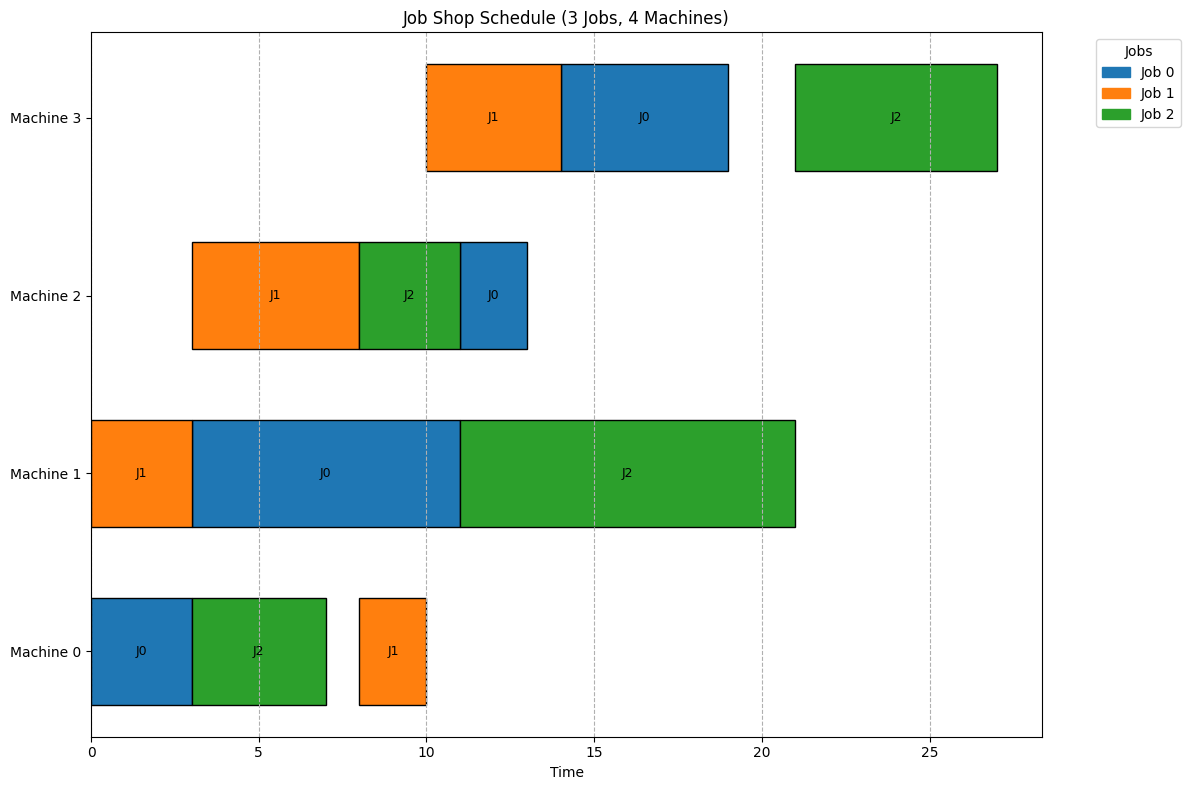

In [31]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Prepare data for plotting
chart_data = []
job_colors = list(mcolors.TABLEAU_COLORS.values())[:num_jobs]

for j in range(num_jobs):
    for op_idx, m in enumerate(machine_order[j]):
        start = pulp.value(start_time[m, j])
        duration = processing_time[j][op_idx]
        finish = start + duration
        chart_data.append({
            'job': j,
            'machine': m,
            'start': start,
            'duration': duration,
            'finish': finish,
            'color': job_colors[j % len(job_colors)]
        })

# Create Gantt chart
fig, ax = plt.subplots(figsize=(12, 6 + num_machines * 0.5))

# Sort data by machine for better visualization
chart_data.sort(key=lambda x: x['machine'])

for item in chart_data:
    ax.barh(
        item['machine'],
        item['duration'],
        left=item['start'],
        color=item['color'],
        height=0.6,
        edgecolor='black'
    )
    # Add text label for job number
    ax.text(
        item['start'] + item['duration'] / 2,
        item['machine'],
        f'J{item['job']}',
        va='center',
        ha='center',
        color='black', # Changed to always use black text
        fontsize=9
    )

# Customize the chart
ax.set_yticks(range(num_machines))
ax.set_yticklabels([f'Machine {i}' for i in range(num_machines)])
ax.set_xlabel('Time')
ax.set_title('Job Shop Schedule (3 Jobs, 4 Machines)')
ax.grid(True, axis='x', linestyle='--')

# Create custom legend
handles = [plt.Rectangle((0,0),1,1, color=job_colors[j % len(job_colors)]) for j in range(num_jobs)]
labels = [f'Job {j}' for j in range(num_jobs)]
ax.legend(handles, labels, title='Jobs', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Excercise 1b:
Play with the code above, see how the Cmax changes with different processing times, different variations of the problem.
# Excercise 2

Add a machine to the problem. Use %%timeit to see how the solver performance changes.

# Excercise 3:

Make the problem interactive, add a way to specify the number of jobs and machines interactively

In [47]:
num_jobs = int(input("Enter the number of jobs: "))
num_machines = int(input("Enter the number of machines: "))

print(f"Solving for {num_jobs} jobs and {num_machines} machines.")

Enter the number of jobs: 7
Enter the number of machines: 20
Solving for 7 jobs and 20 machines.


In [48]:
import random

# Generate random machine_order and processing_time
machine_order = []
processing_time = []

for _ in range(num_jobs):
    # Each job visits all machines in a random unique order
    job_machine_sequence = random.sample(range(num_machines), num_machines)
    machine_order.append(job_machine_sequence)

    # Generate random processing times for each operation (between 1 and 10 units)
    job_processing_times = [random.randint(1, 10) for _ in range(num_machines)]
    processing_time.append(job_processing_times)

print("Generated machine order:", machine_order)
print("Generated processing times:", processing_time)

Generated machine order: [[11, 19, 5, 3, 4, 16, 13, 2, 15, 17, 12, 0, 6, 10, 18, 9, 14, 8, 7, 1], [1, 15, 10, 5, 17, 2, 12, 4, 13, 11, 8, 14, 7, 9, 6, 16, 0, 18, 19, 3], [6, 1, 15, 18, 2, 0, 12, 10, 17, 14, 5, 7, 3, 19, 11, 9, 16, 13, 4, 8], [4, 9, 12, 7, 0, 11, 5, 8, 16, 3, 10, 19, 1, 18, 13, 15, 17, 6, 14, 2], [9, 19, 6, 15, 7, 3, 0, 16, 14, 8, 13, 1, 4, 2, 11, 12, 5, 10, 18, 17], [19, 3, 18, 17, 5, 14, 15, 0, 13, 11, 8, 2, 1, 6, 12, 4, 16, 10, 7, 9], [14, 7, 15, 1, 9, 12, 4, 17, 0, 16, 10, 2, 5, 19, 11, 18, 6, 3, 8, 13]]
Generated processing times: [[6, 2, 6, 3, 6, 6, 2, 4, 4, 4, 4, 8, 9, 4, 2, 1, 1, 5, 10, 7], [9, 1, 6, 6, 7, 9, 1, 8, 3, 3, 3, 7, 8, 10, 7, 9, 7, 3, 10, 5], [9, 1, 8, 7, 4, 8, 10, 6, 6, 10, 8, 1, 3, 10, 7, 1, 9, 6, 1, 9], [8, 6, 5, 3, 1, 3, 8, 6, 9, 3, 9, 6, 2, 7, 1, 9, 1, 10, 5, 2], [5, 6, 7, 3, 8, 8, 7, 10, 10, 8, 5, 7, 1, 5, 7, 8, 3, 1, 2, 7], [6, 2, 8, 10, 4, 10, 6, 10, 1, 2, 7, 10, 5, 1, 2, 7, 1, 5, 4, 8], [10, 10, 4, 10, 7, 5, 5, 9, 1, 4, 2, 3, 4, 7, 1, 9, 2, 6

In [49]:
import pulp

# -------------------------
# 2) DECISION VARIABLES
# -------------------------
# start_time[m, j] = the start time of Job j on Machine m.
start_time = pulp.LpVariable.dicts(
    "start_time",
    [(m, j) for m in range(num_machines) for j in range(num_jobs)],
    lowBound=0,
    cat='Continuous'
)

# Cmax to represent the makespan.
Cmax = pulp.LpVariable('Cmax', lowBound=0, cat='Continuous')

# -------------------------
# 3) MODEL
# -------------------------
model = pulp.LpProblem("Job_Shop_Scheduling_Dynamic", pulp.LpMinimize)

# Objective: Minimize the makespan
model += Cmax, "Minimize_makespan"

# -------------------------
# 4) CONSTRAINTS
# -------------------------

# (A) **Operation sequence** constraints:
# For each job j, each operation must start after the previous one finishes.
for j in range(num_jobs):
    for op_idx in range(num_machines - 1):
        current_machine = machine_order[j][op_idx]
        next_machine = machine_order[j][op_idx + 1]
        current_op_time = processing_time[j][op_idx]

        model += start_time[next_machine, j] >= (
            start_time[current_machine, j] + current_op_time
        ), f"SequenceConstraint_Job{j}_Op{op_idx}"

# (B) **No overlap on the same machine**:
# If two jobs j1 and j2 require the same machine m, only one can run at a time.
bigM = sum(sum(p) for p in processing_time) + 1 # A sufficiently large M

# Binary variables that indicate ordering between job pairs on each machine.
y = pulp.LpVariable.dicts(
    "y",
    [(m, j1, j2) for m in range(num_machines) for j1 in range(num_jobs) for j2 in range(num_jobs) if j1 != j2], # Only if j1 and j2 are different
    cat='Binary'
)

for m in range(num_machines):
    # Iterate over all unique pairs of jobs (j1, j2)
    for j1_idx in range(num_jobs):
        for j2_idx in range(j1_idx + 1, num_jobs):
            j1 = j1_idx
            j2 = j2_idx

            # Check if both jobs use machine m
            if m in machine_order[j1] and m in machine_order[j2]:
                op_j1_idx = machine_order[j1].index(m)
                proc_j1 = processing_time[j1][op_j1_idx]

                op_j2_idx = machine_order[j2].index(m)
                proc_j2 = processing_time[j2][op_j2_idx]

                # Non-overlap constraints:
                # If job j1 comes before j2 on machine m (y[m, j1, j2] = 1):
                model += start_time[m, j2] >= start_time[m, j1] + proc_j1 - bigM * (1 - y[m, j1, j2]), f"NoOverlap_M{m}_J{j1}_J{j2}_Order1"
                # If job j2 comes before j1 on machine m (y[m, j1, j2] = 0):
                model += start_time[m, j1] >= start_time[m, j2] + proc_j2 - bigM * (y[m, j1, j2]), f"NoOverlap_M{m}_J{j1}_J{j2}_Order2"

# (C) **Makespan definition**:
# For each job j, the finishing time on its last machine must be <= Cmax.
for j in range(num_jobs):
    last_op_idx = num_machines - 1
    last_machine_for_job_j = machine_order[j][last_op_idx]
    finish_time_j = start_time[last_machine_for_job_j, j] + processing_time[j][last_op_idx]
    model += Cmax >= finish_time_j, f"CmaxConstraint_Job{j}"

# -------------------------
# 5) SOLVE
# -------------------------
model.solve(pulp.PULP_CBC_CMD(msg=False))

print("\nSolution Status:", pulp.LpStatus[model.status])
print("Objective (makespan) =", pulp.value(model.objective))

# Print the start times
print("\n--- Start Times ---")
for j in range(num_jobs):
    for op_idx in range(num_machines):
        m = machine_order[j][op_idx]
        print(f"Start time of Job {j} on Machine {m} (Op {op_idx}) = {pulp.value(start_time[m, j])}")



Solution Status: Optimal
Objective (makespan) = 137.0

--- Start Times ---
Start time of Job 0 on Machine 11 (Op 0) = 0.0
Start time of Job 0 on Machine 19 (Op 1) = 12.0
Start time of Job 0 on Machine 5 (Op 2) = 35.0
Start time of Job 0 on Machine 3 (Op 3) = 44.0
Start time of Job 0 on Machine 4 (Op 4) = 47.0
Start time of Job 0 on Machine 16 (Op 5) = 56.0
Start time of Job 0 on Machine 13 (Op 6) = 62.0
Start time of Job 0 on Machine 2 (Op 7) = 64.0
Start time of Job 0 on Machine 15 (Op 8) = 68.0
Start time of Job 0 on Machine 17 (Op 9) = 72.0
Start time of Job 0 on Machine 12 (Op 10) = 76.0
Start time of Job 0 on Machine 0 (Op 11) = 80.0
Start time of Job 0 on Machine 6 (Op 12) = 88.0
Start time of Job 0 on Machine 10 (Op 13) = 97.0
Start time of Job 0 on Machine 18 (Op 14) = 101.0
Start time of Job 0 on Machine 9 (Op 15) = 103.0
Start time of Job 0 on Machine 14 (Op 16) = 104.0
Start time of Job 0 on Machine 8 (Op 17) = 105.0
Start time of Job 0 on Machine 7 (Op 18) = 110.0
Start ti

In [50]:
%%timeit -n 1 -r 1
model.solve(pulp.PULP_CBC_CMD(msg=False))

9.45 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


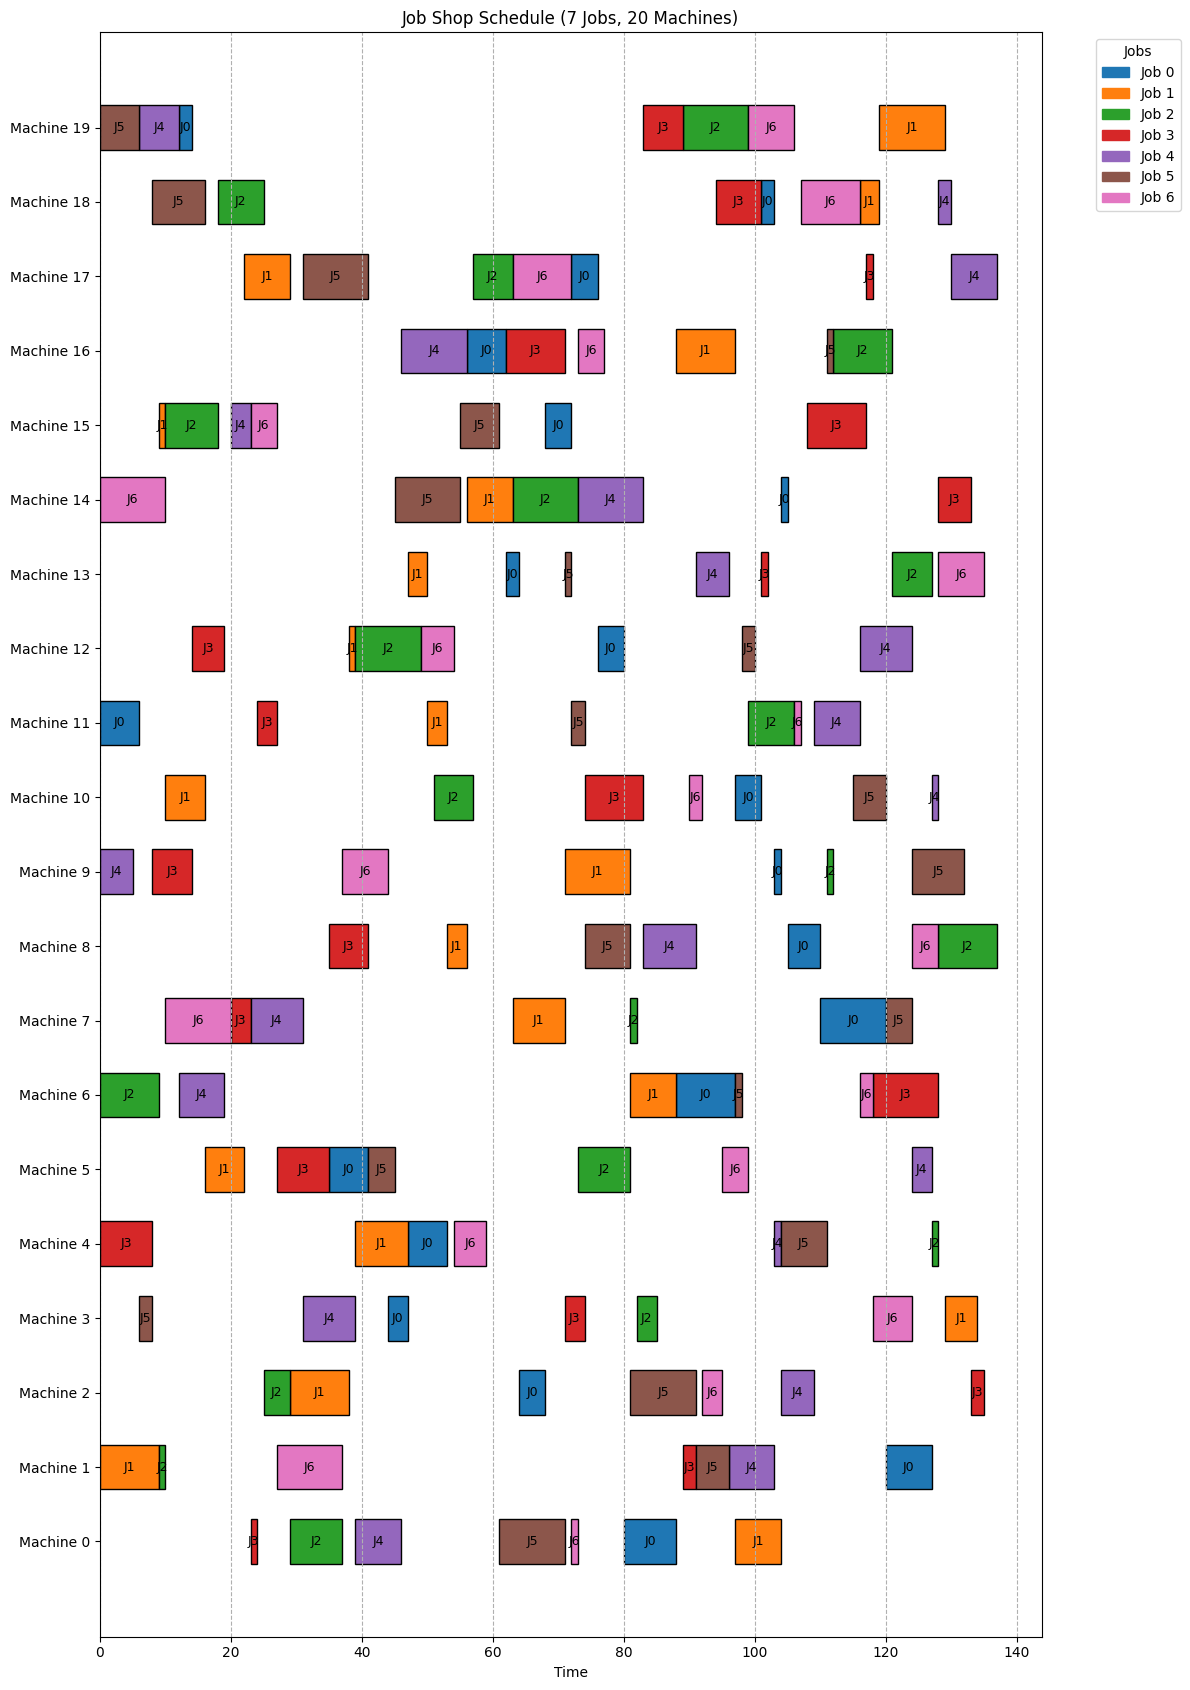

In [51]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Prepare data for plotting
chart_data = []
job_colors = list(mcolors.TABLEAU_COLORS.values())[:num_jobs] # Ensure enough colors for jobs

for j in range(num_jobs):
    for op_idx, m in enumerate(machine_order[j]):
        start = pulp.value(start_time[m, j])
        duration = processing_time[j][op_idx]
        finish = start + duration
        chart_data.append({
            'job': j,
            'machine': m,
            'start': start,
            'duration': duration,
            'finish': finish,
            'color': job_colors[j % len(job_colors)]
        })

# Create Gantt chart
fig, ax = plt.subplots(figsize=(12, 0.8 * num_machines + 1)) # Adjust figure height dynamically

# Sort data by machine for better visualization
chart_data.sort(key=lambda x: x['machine'])

for item in chart_data:
    ax.barh(
        item['machine'],
        item['duration'],
        left=item['start'],
        color=item['color'],
        height=0.6,
        edgecolor='black'
    )
    # Add text label for job number
    ax.text(
        item['start'] + item['duration'] / 2,
        item['machine'],
        f'J{item['job']}',
        va='center',
        ha='center',
        color='black',
        fontsize=9
    )

# Customize the chart
ax.set_yticks(range(num_machines))
ax.set_yticklabels([f'Machine {i}' for i in range(num_machines)])
ax.set_xlabel('Time')
ax.set_title(f'Job Shop Schedule ({num_jobs} Jobs, {num_machines} Machines)')
ax.grid(True, axis='x', linestyle='--')

# Create custom legend
handles = [plt.Rectangle((0,0),1,1, color=job_colors[j % len(job_colors)]) for j in range(num_jobs)]
labels = [f'Job {j}' for j in range(num_jobs)]
ax.legend(handles, labels, title='Jobs', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


The problem can be very hard for a larger number of jobs and machines. There are some heuristics that can be used to solve it. Some interesting methods are:
- Genetic algorithms
- Simulated annealing
- Tabu search
- Ant colony optimization
- Particle swarm optimization
